In [3]:
PATH_DATAS = 'C:/Users/zfriant/Documents/OneDrive/PCRI/eCorda_datas/'
PATH_REF = f"{PATH_DATAS}datas_reference/"
PATH_CLEAN = f"{PATH_DATAS}datas_clean/"
PATH_WORK='C:/Users/zfriant/Documents/OneDrive/PCRI/eCorda_datas/datas_work/'
FRAMEWORK='HORIZON'

from IPython.display import HTML
import requests, json, os, pandas as pd, datetime as dt, time, urllib3, re, numpy as np, pandas.api.types as pat, copy, openpyxl
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

In [123]:
id_rgp = pd.read_csv(f"{PATH_REF}id_paysage_rgp.csv", sep=';', encoding='ANSI')
proj = pd.read_pickle(f"{PATH_WORK}projects_all_FW.pkl")
entities = pd.read_pickle(f"{PATH_WORK}entities_participation_current.pkl")

In [124]:
ent = entities.loc[entities.stage=='successful', ['project_id', 'entities_id', 'entities_name', 'erc_role', 'role', 'participates_as', 'operateur_name', 'country_code', 'country_name_fr', 'calculated_fund']].drop_duplicates()

In [126]:
x = proj.loc[proj.framework.isin(['Horizon Europe', 'Horizon 2020']), ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'free_keywords']]

In [131]:
y=pd.DataFrame()

for i in ['title', 'abstract', 'topic_name', 'free_keywords']:
         
    x[f'{i}2'] = x[i].str.replace(r" \(.*\)","", regex=True).str.lower()  
    y = pd.concat([y, x.loc[x[f'{i}2'].str.contains('artificial intelligence|machine learning|neural network|deep learning|image processing|natural language processing', na=False)]], ignore_index=True)
    y = y.filter(regex=r'.*(?<!2)$')

In [133]:
p=(y.merge(ent, how ='inner', on='project_id')
   .drop_duplicates()
   .merge(id_rgp, how='left', left_on='entities_id', right_on='id_paysage')
   .drop_duplicates())

In [134]:
p.columns
len(p)
#29593

20841

In [155]:
# p[p.project_id=='101109907']
p.loc[p.topic_code.str.contains('PF'),['role', 'participates_as']].drop_duplicates()

,role,participates_as
13,partner,associated partner
14,coordinator,beneficiary


In [136]:
p_erc=p.loc[(p.topic_code.str.contains('ERC-'))&(p.erc_role=='PI')&(p.country_code=='FRA'), ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'id_paysage_RGP', 'id_paysage_RGP_lib', 'entities_id', 'entities_name', 'operateur_name', 'erc_role' , 'calculated_fund']]

In [137]:
p_ia=p.loc[(~p.topic_code.str.contains('ERC-'))&(p.country_code=='FRA'), ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'id_paysage_RGP', 'id_paysage_RGP_lib', 'entities_id', 'entities_name', 'operateur_name', 'calculated_fund']]

In [139]:
def source(tab: pd.DataFrame):
    fund_tot = tab.calculated_fund.sum()
    proj_tot = tab.project_id.nunique()
    tab = tab.groupby(['id_paysage_RGP_lib', 'id_paysage_RGP']).agg({'calculated_fund':'sum', 'project_id':'nunique'}).reset_index()
    tab['fund_share'] = round(tab['calculated_fund'] / fund_tot*100, 1)
    tab['proj_share'] = round(tab['project_id'] / proj_tot*100, 1)
    return tab

In [140]:
p_ia_share=source(p_ia)
p_ia_erc=source(p_erc)

In [141]:
import re
def format_label(x):
    current_str=''
    res=[]
    for c in re.split(' |-', x):
        if len(current_str)<15:
            current_str+=c+' '
        else:
            res.append(current_str)
            current_str=c+' '
    res.append(current_str)
    return '\n'.join(res).strip()
            
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
SIZE = 22
SMALL_SIZE=18
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title       

In [142]:
color_dict = {}
color_dict['Université Paris-Saclay'] = '#63003C'
color_dict['Alliance Sorbonne Université'] = '#042f66'
color_dict['Université Grenoble Alpes'] = '#FF4E01'
color_dict['Institut polytechnique de Paris'] = 'black'
color_dict['Université Paris sciences et lettres']='#2F3B89'
color_dict['Université de Lorraine'] ='#FFF044'
color_dict['Université de Toulouse'] = '#BE2125'
color_dict['Université de Rennes'] = '#59a14f'
color_dict["Université Côte d'Azur"] = "#007FA5"
color_dict['Université de Strasbourg'] = '#303030'

In [143]:
def top(tab, value: str):
       
    TOP = 20
    top_etab = [{'etab': x, 'label': format_label(x)} for x in tab.id_paysage_RGP_lib.to_list()]
    top_val = tab[value].to_list()

    top_etab_filtered, top_val_filtered = [], []
    for ix, t in enumerate(top_etab):
        if len(top_etab_filtered) == TOP:
            break
        top_etab_filtered.append(t)
        top_val_filtered.append(top_val[ix])

    colors = ['grey']*TOP
    for ix, etab in enumerate(top_etab_filtered):
        if etab['etab'] in color_dict:
            colors[ix] = color_dict[etab['etab']]
            
    return top_etab_filtered, top_val_filtered, colors

C:\Users\zfriant\AppData\Local\Temp\ipykernel_13660\1461624496.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


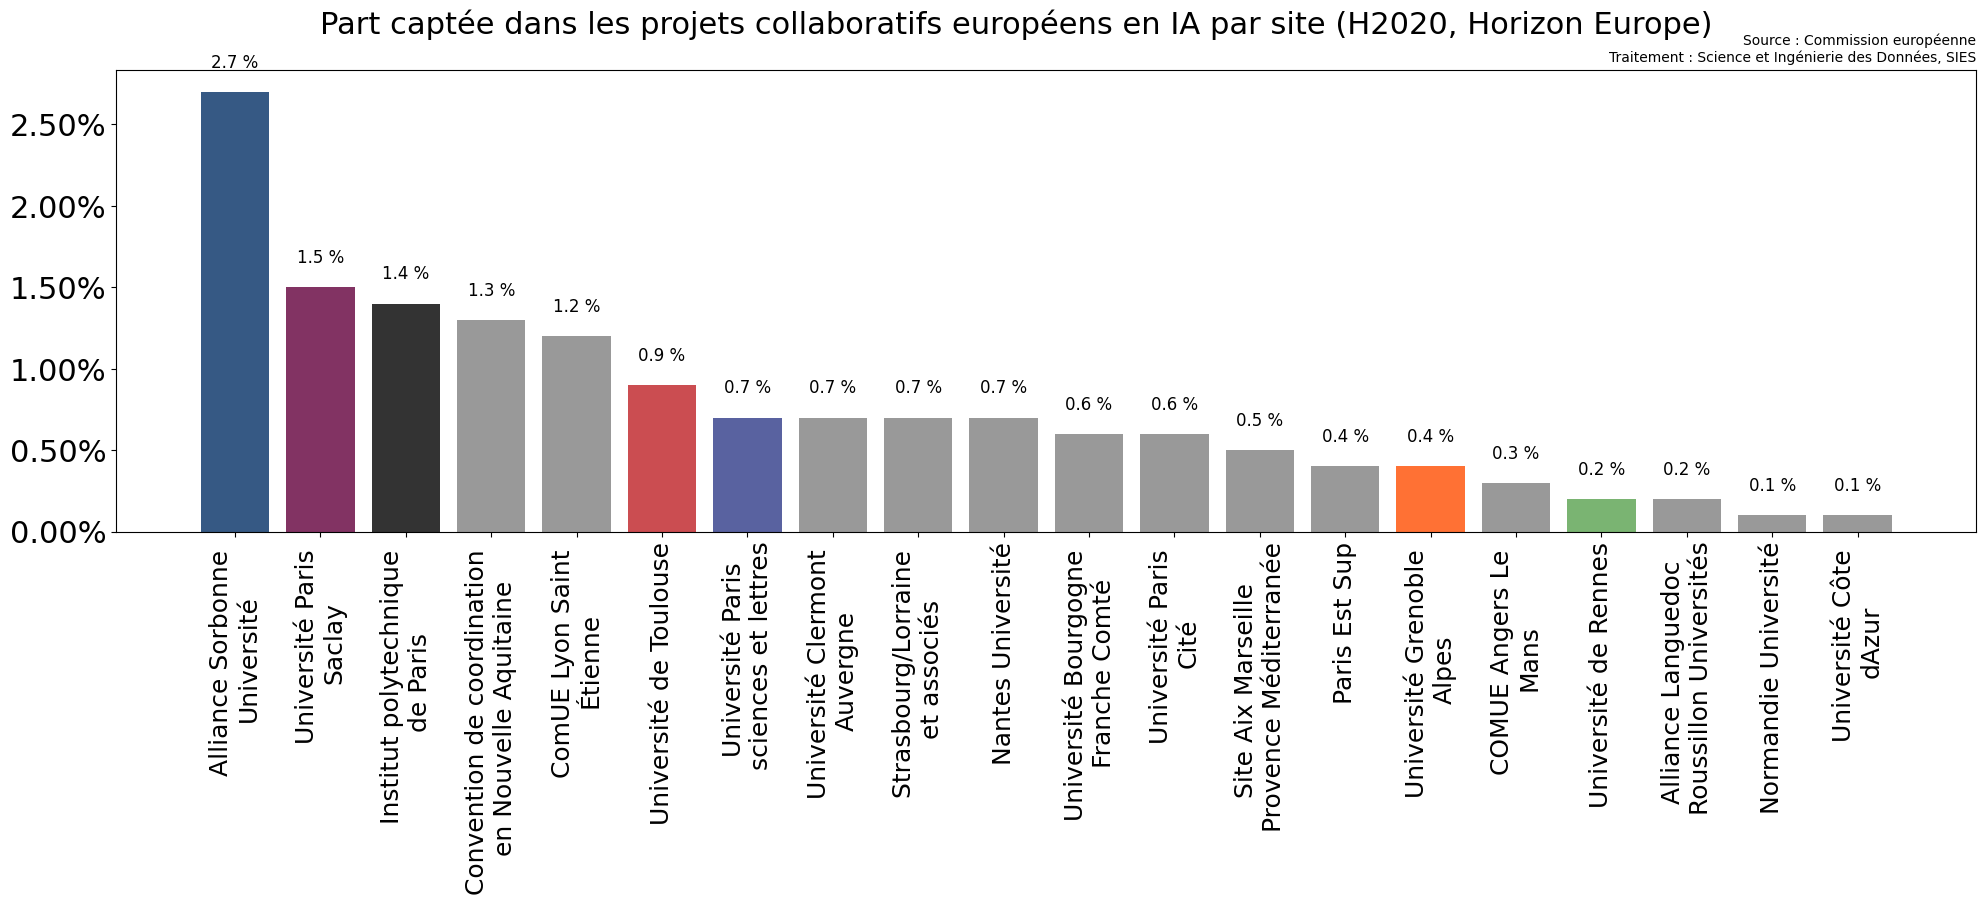

In [144]:
p_ia_share=p_ia_share.sort_values('fund_share', ascending=False, ignore_index=True)
top_etab_filtered = top(p_ia_share, 'fund_share')[0]
top_val_filtered = top(p_ia_share, 'fund_share')[1]
colors = top(p_ia_share, 'fund_share')[2]

fig, ax = plt.subplots(figsize=(24,6), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_val_filtered, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Part captée dans les projets collaboratifs européens en IA par site (H2020, Horizon Europe)")
plt.title('Source : Commission européenne\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_etab_filtered)):
    plt.text(i, top_val_filtered[i]+0.15, str(top_val_filtered[i])+' %', ha = 'center', fontsize=12)

C:\Users\zfriant\AppData\Local\Temp\ipykernel_13660\3737452350.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


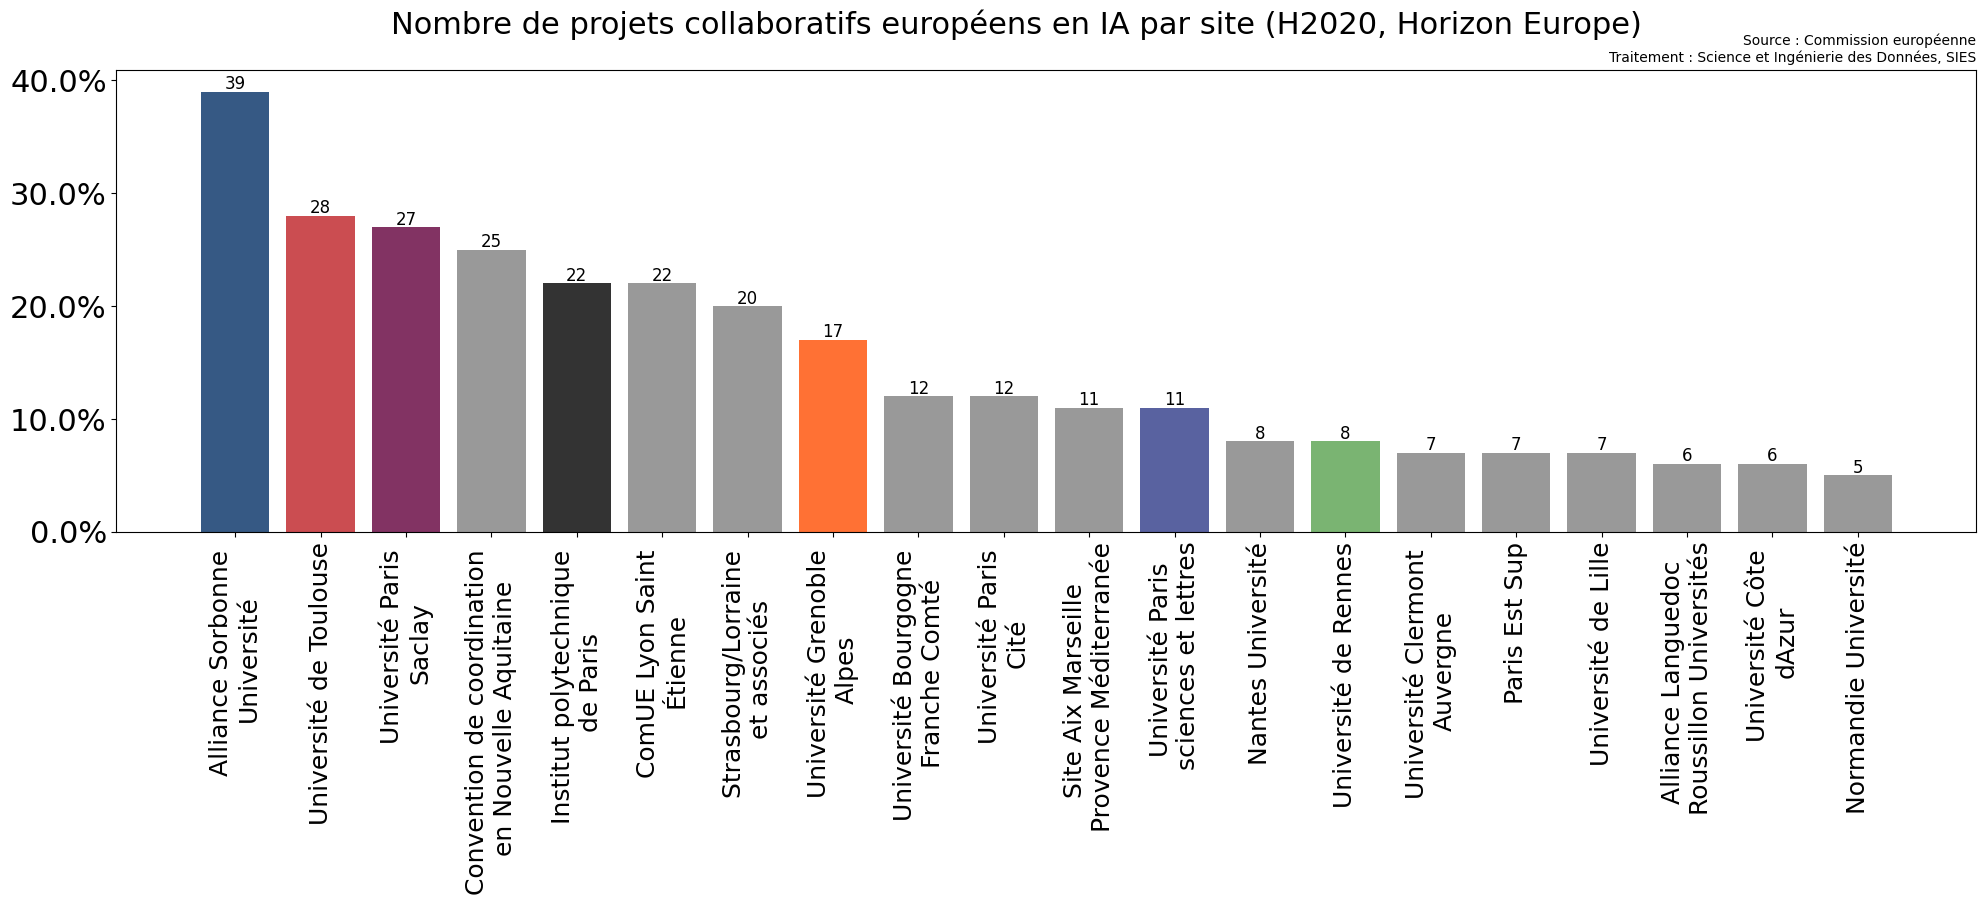

In [145]:
p_ia_share=p_ia_share.sort_values('project_id', ascending=False, ignore_index=True)
top_etab_filtered, top_val_filtered, colors = top(p_ia_share, 'project_id')

fig, ax = plt.subplots(figsize=(24,6), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_val_filtered, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Nombre de projets collaboratifs européens en IA par site (H2020, Horizon Europe)")
plt.title('Source : Commission européenne\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_etab_filtered)):
    plt.text(i, top_val_filtered[i]+0.25, str(top_val_filtered[i]), ha = 'center', fontsize=12)

### ERC

C:\Users\zfriant\AppData\Local\Temp\ipykernel_13660\530461198.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


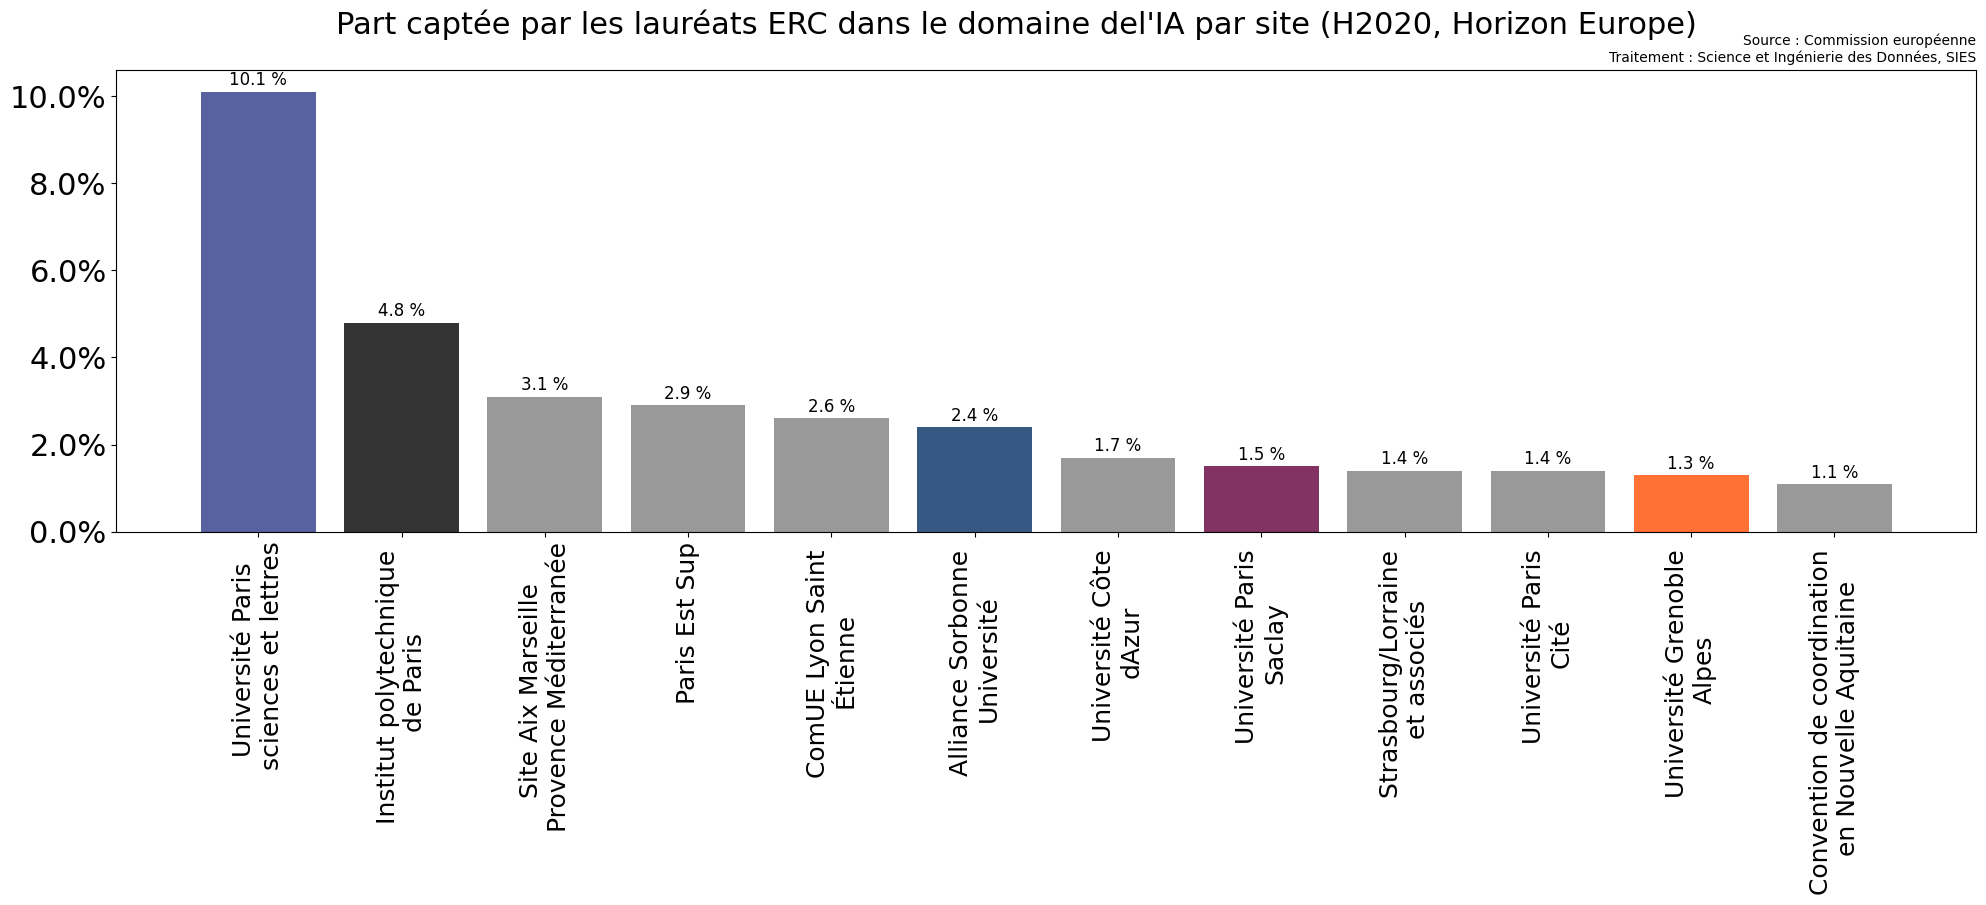

In [146]:
p_ia_erc=p_ia_erc.sort_values('fund_share', ascending=False, ignore_index=True)
top_etab_filtered, top_val_filtered, colors = top(p_ia_erc, 'fund_share')

fig, ax = plt.subplots(figsize=(24,6), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_val_filtered, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Part captée par les lauréats ERC dans le domaine del'IA par site (H2020, Horizon Europe)")
plt.title('Source : Commission européenne\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_etab_filtered)):
    plt.text(i, top_val_filtered[i]+0.15, str(top_val_filtered[i])+' %', ha = 'center', fontsize=12)

C:\Users\zfriant\AppData\Local\Temp\ipykernel_13660\4098833858.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


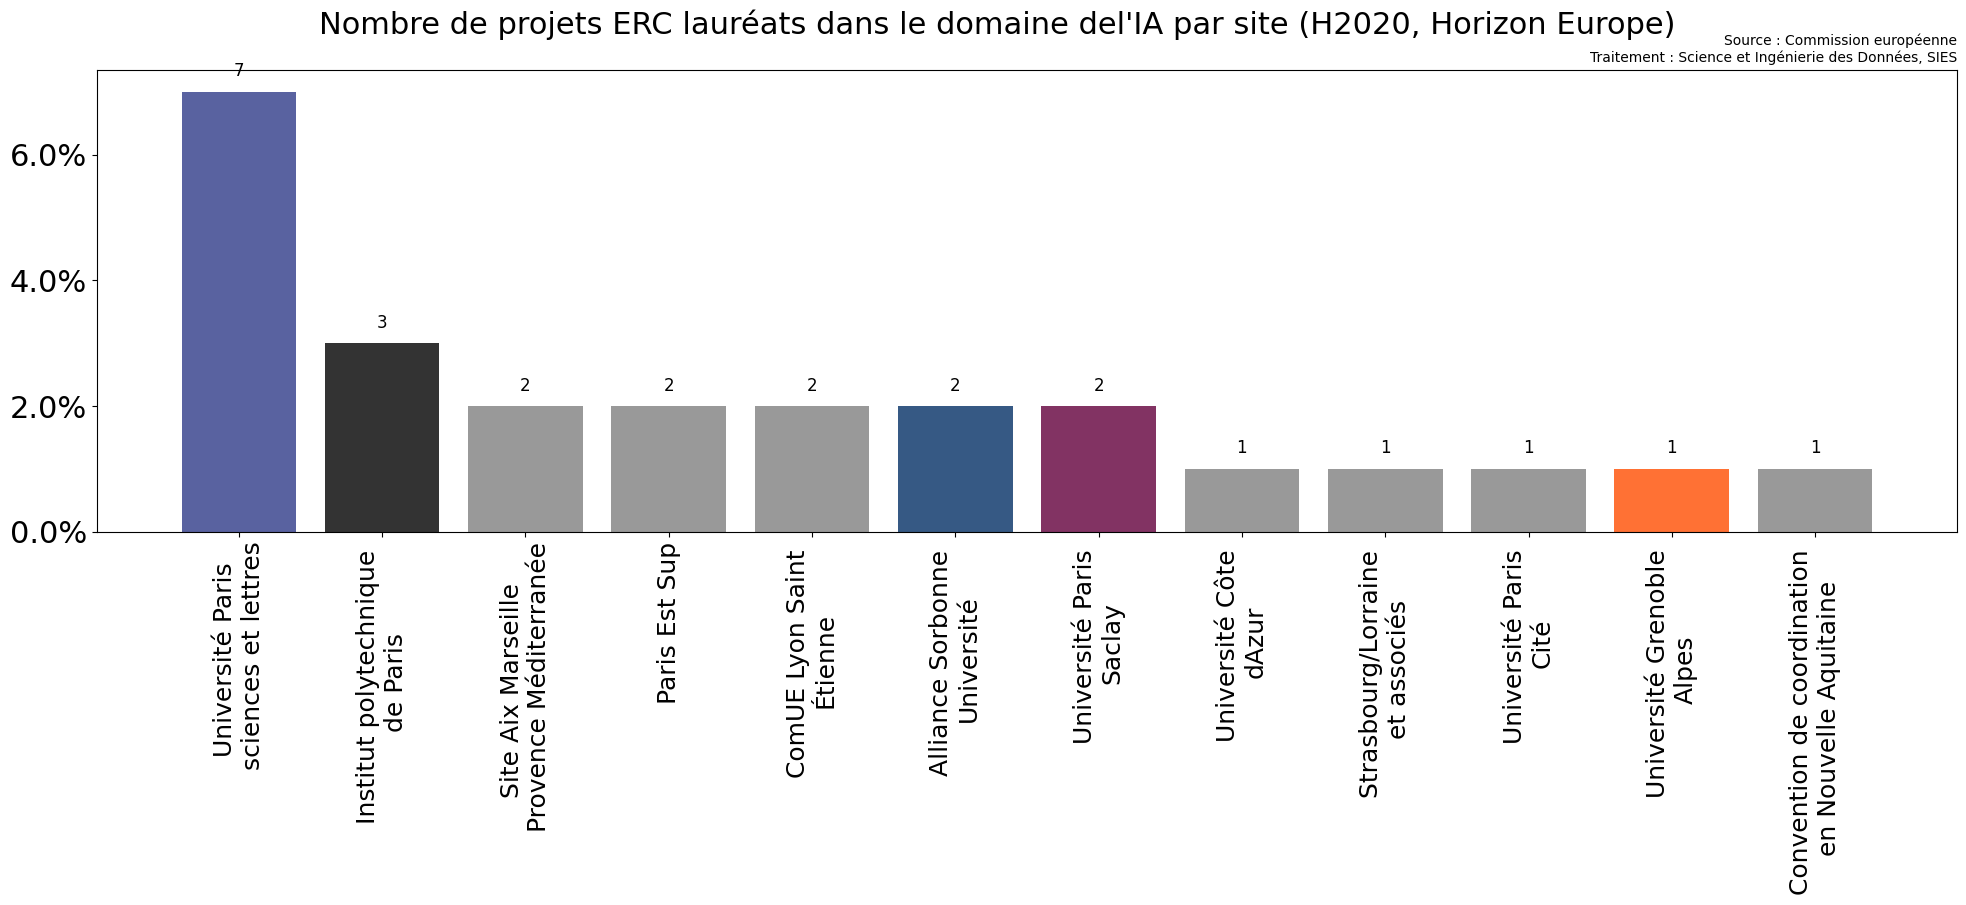

In [147]:
p_ia_erc=p_ia_erc.sort_values('project_id', ascending=False, ignore_index=True)
top_etab_filtered, top_val_filtered, colors = top(p_ia_erc, 'project_id')

fig, ax = plt.subplots(figsize=(24,6), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_val_filtered, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Nombre de projets ERC lauréats dans le domaine del'IA par site (H2020, Horizon Europe)")
plt.title('Source : Commission européenne\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_etab_filtered)):
    plt.text(i, top_val_filtered[i]+0.25, str(top_val_filtered[i]), ha = 'center', fontsize=12)